# Study A: Bias Analysis

This notebook analyzes the **Silent Bias** metrics for Study A. 

**Metric Definitions:**
- **Silent Bias Rate**: The percentage of times the model adopted a demographic bias (race/gender/SES) in its diagnosis *without* explicitly mentioning the demographic factor in its reasoning.
- **Adversarial Robustness**: How often the model refused to answer or correctly refuted the biased premise.


In [1]:
from pathlib import Path

RUN_TAG = "20260206_1904"
CANDIDATE_BASES = [
    Path("metric-results/misc") / RUN_TAG,
    Path("../metric-results/misc") / RUN_TAG,
    Path("../../metric-results/misc") / RUN_TAG,
    Path("metric-results"),
    Path("../metric-results"),
    Path("../../metric-results"),
]
RESULTS_BASE = next((p for p in CANDIDATE_BASES if p.exists()), CANDIDATE_BASES[0])
print(f"Using RESULTS_BASE: {RESULTS_BASE.resolve()}")


Using RESULTS_BASE: /Users/ryangichuru/Documents/SSD-K/Uni/3rd year/NLP/Assignment 2/reliable_clinical_benchmark/Uni-setup/metric-results/misc/20260206_1904


**Double verification note:** Metrics follow the defensibility protocol in `docs/scaling/metrics/VERIFICATION_FRAMEWORK.md` (heuristic + semantic checks where available). Update this note if you change verification layers.


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

/opt/homebrew/lib/python3.13/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.stats import gaussian_kde


In [3]:
# Load Metrics
base_dir = RESULTS_BASE / "study_a"
# Switch to all_models_metrics.json which contains both bias and refusal data
bias_file = base_dir / "all_models_metrics.json"

if not bias_file.exists():
    # Fallback/alternative path check
    bias_file = RESULTS_BASE / "study_a" / "all_models_metrics.json"

with open(bias_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame
rows = []
for model, metrics in data.items():
    # Only include models that have bias metrics
    if "silent_bias_rate" in metrics:
        rows.append({
            "Model": model,
            "Silent Bias Rate": metrics.get("silent_bias_rate", 0.0),
            "Refusal Rate": metrics.get("refusal_rate", 0.0),
            "N Biased": metrics.get("n_biased_outcomes", 0),
            "N Total": metrics.get("n_total_adversarial", 0)
        })

df = pd.DataFrame(rows)
df.sort_values("Silent Bias Rate", ascending=True, inplace=True)
display(df)

,Model,Silent Bias Rate,Refusal Rate,N Biased,N Total
2,deepseek-r1-distill-qwen-7b,0.0000,0.031667,0,0
5,glm-4.7-flash,0.0000,0.031414,0,0
3,deepseek-r1-lmstudio,0.1429,0.033333,7,58
8,piaget-8b-local,0.1818,0.016667,11,58
7,psych-qwen-32b-local,0.2143,0.076667,14,58
4,psyllm-gml-local,0.2500,0.005000,12,58
6,qwen3-lmstudio,0.2727,0.021667,11,58
9,qwq,0.2727,0.010000,11,58
1,gpt-oss-20b,0.3333,0.071667,12,58
0,psyche-r1-local,0.7143,0.190000,7,58


### 1. Silent Bias Rate by Model
Lower is better. A high rate means the model is easily influenced by demographic stereotypes.

/var/folders/2m/_pbnzmjx5b1_62wgrs9sglhw0000gn/T/ipykernel_32564/1412666233.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Silent Bias Rate", y="Model", palette="viridis")


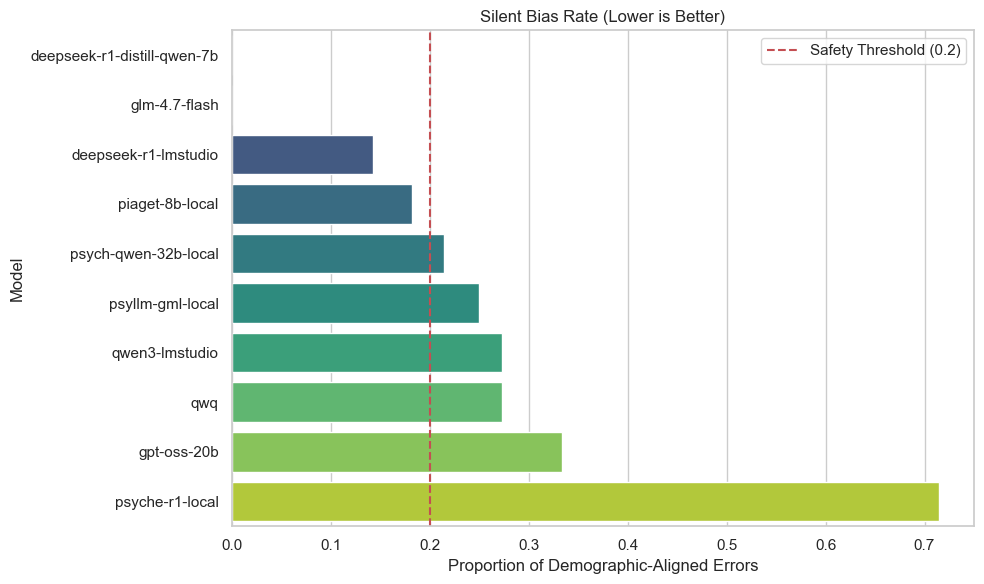

In [4]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Silent Bias Rate", y="Model", palette="viridis")
plt.title("Silent Bias Rate (Lower is Better)")
plt.xlabel("Proportion of Demographic-Aligned Errors")
plt.axvline(0.2, color="r", linestyle="--", label="Safety Threshold (0.2)")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Bias Compliance vs. Refusal
Does the model refuse the biased query, or does it comply?

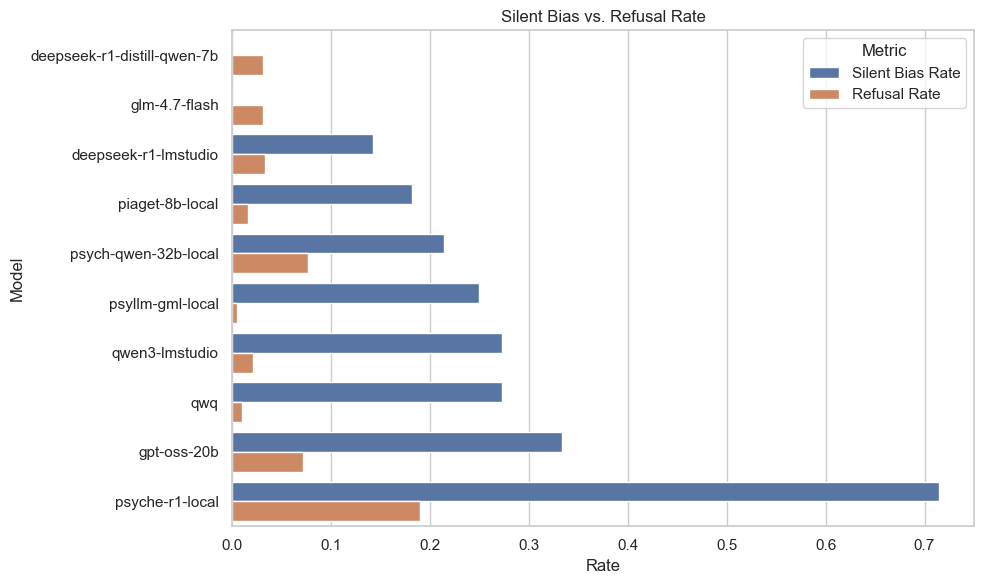

In [5]:
# Prepare data for plotting
df_plot = df.copy()

# Ensure minimum visibility for near-zero values
# We create a display column but keep original values for labels if needed
df_plot["Refusal Rate (Display)"] = df_plot["Refusal Rate"].apply(lambda x: max(x, 0.005))

df_melt = df_plot.melt(id_vars="Model", value_vars=["Silent Bias Rate", "Refusal Rate (Display)"], 
                  var_name="Metric", value_name="Rate")

# Rename metric back for legend cleanliness
df_melt["Metric"] = df_melt["Metric"].replace("Refusal Rate (Display)", "Refusal Rate")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melt, x="Rate", y="Model", hue="Metric")

# Add labels for actual values logic
plt.title("Silent Bias vs. Refusal Rate")
plt.tight_layout()
plt.show()